# Exercício de Fundamentos e Práticas de Deep Learning - Marco Aurélio Garcia
## Criação de Um sistema de reconhecimento facial

O presente notebook tem o objetivo de resolver o desafio final do curso de Machine Learning - Fundamentos e Práticas de Deep Learning, criando uma processo automatizado para realizar o reconhecimento facial. O presente trabalho tomou como base o tutorial https://docs.opencv.org/4.x/d0/dd4/tutorial_dnn_face.html que utiliza as classes FaceDetectorYN e FaceRecognizerSF da biblioteca OpenCV.

O processo segue conforme os seguintes passos:

1 - Importação dos pacotes e definição das funções e variáveis globais

2 - Definição do caminho para a imagem onde há as referências de faces para serem cadastradas. Deve ser uma imagem com várias faces para detecção e identificação.

3 - O processo apresenta a imagem recém selecionada com a sequência esperada de nomes das pessoas, que deve ser registrada na lista lista_identidades

4 - Após alterações dos nomes no objeto lista_identidades, basta definir o nome do novo arquivo com outra imagem para então realizar a detecção e reconhecimento conforme registro na lista_identidades.

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


# Definição da função para apresentação da imagem no notebook
def show_image(img, title="Image"):
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Definição da função utilizada para desenhar o retângulo nas faces, registrar os pontos chaves faciais e registrar os labels adequados
def visualize(input, faces, fps, thickness=1, labels=None):
    if faces[1] is not None:
        for idx, face in enumerate(faces[1]):
            coords = face[:-1].astype(np.int32)
            x, y, w, h = coords[0], coords[1], coords[2], coords[3]

            # Caixa do rosto
            cv.rectangle(input, (x, y), (x + w, y + h), (0, 255, 0), thickness)

            # Pontos-chave (olhos, boca, etc.)
            for i in range(4, 14, 2):
                cv.circle(input, (coords[i], coords[i + 1]), 2, (0, 255, 255), thickness)

            # Rótulo do rosto (se fornecido)
            if labels and idx < len(labels):
                label = labels[idx]
            else:
                label = f"Pessoa {idx+1}"

            cv.putText(input, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)


# Definição de variáveis, hiperparâmetros e referências para os modelos de detecção e reconhecimento

save_result = False # Caso seja necessário salvar as imagens geradas pelo processo

img1_base = None
faces1 = None

scale = 1.0
score_threshold = 0.9
nms_threshold = 0.3
top_k = 5000

# Modelos
face_detection_model = 'C:/opencv/face_detection_yunet_2023mar.onnx'
face_recognition_model = 'C:/opencv/face_recognition_sface_2021dec.onnx'


# Detector facial
detector = cv.FaceDetectorYN.create(
    face_detection_model,
    "",
    (320, 320),
    score_threshold,
    nms_threshold,
    top_k
)

# Medidor de tempo
tm = cv.TickMeter()

# Define a função que identifica as faces na imagem de referência
def identifica_faces(image_path):
    img1 = cv.imread(image_path)
    if img1 is None:
        raise FileNotFoundError(f'Imagem {image_path} não encontrada.')
    
    img1 = cv.resize(img1, (int(img1.shape[1] * scale), int(img1.shape[0] * scale)))
    img1_base = cv.resize(img1, (int(img1.shape[1] * scale), int(img1.shape[0] * scale)))
    detector.setInputSize((img1.shape[1], img1.shape[0]))
    
    tm.start()
    faces1 = detector.detect(img1)
    tm.stop()
    
    assert faces1[1] is not None, f'Não foi possível detectar rosto em {image1_path}'
    
    visualize(img1, faces1, tm.getFPS())
    show_image(img1, "Imagem de referência para identificação das pessoas")
    
    if save_result:
        cv.imwrite("imagem_referencia_original.jpg", img1)
    return faces1, img1_base

# Define a função que reconhece as faces presentes na segunda imagem.
def reconhecer_faces(image1_path, image2_path):
    if image1_path and image2_path:
        img1 = cv.imread(image1_path)
        img2 = cv.imread(image2_path)
        if img2 is None:
            raise FileNotFoundError(f'Imagem {image_path} não encontrada.')
        
        detector.setInputSize((img2.shape[1], img2.shape[0]))
        tm.reset()
        tm.start()
        faces2 = detector.detect(img2)
        tm.stop()
        
        assert faces2[1] is not None, f'Não foi possível detectar rosto em {image2_path}'
        pessoas_encontradas=[f"N_Ident_{idx+1}" for idx, face in enumerate(faces2[1])]

        cosine_score=0
        l2_score=0
    
        for idx, face in enumerate(faces1[1]):
            label_idx = ""
            for idx2, face2 in enumerate(faces2[1]):
                # Reconhecimento
                recognizer = cv.FaceRecognizerSF.create(face_recognition_model, "")
                
                face1_align = recognizer.alignCrop(img1, faces1[1][idx])
                face2_align = recognizer.alignCrop(img2, faces2[1][idx2])
                
                feature1 = recognizer.feature(face1_align)
                feature2 = recognizer.feature(face2_align)
                
                cosine_score = recognizer.match(feature1, feature2, cv.FaceRecognizerSF_FR_COSINE)
                l2_score = recognizer.match(feature1, feature2, cv.FaceRecognizerSF_FR_NORM_L2)
            
                if (l2_score <= 1.128) | (cosine_score >= 0.363):
                    pessoas_encontradas[idx2] = lista_identidades[idx]
                    
        visualize(img2, faces2, tm.getFPS(), labels=pessoas_encontradas)
        show_image(img2, f"Reconhecimento de pessoas: cosine_score={cosine_score}, l2_score={l2_score}")

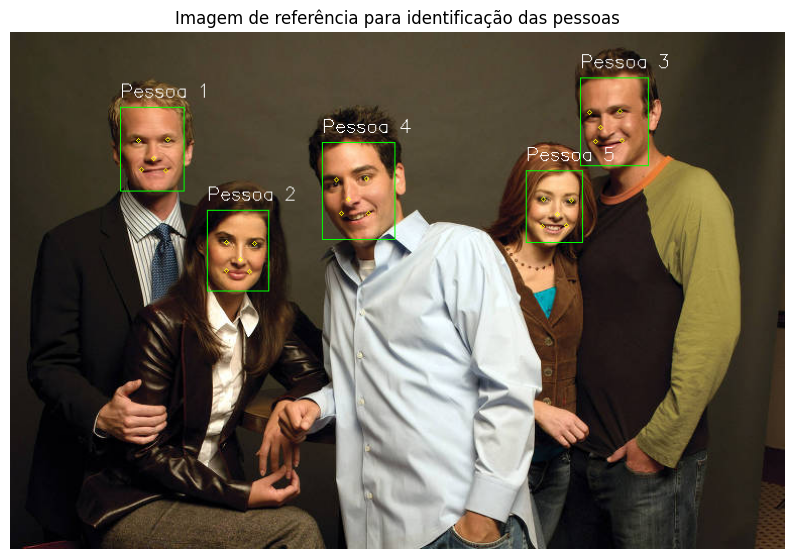

In [2]:
# Defina aqui o caminho para a imagem que será utilizada para referência de classificação das pessoas para reconhecimento
image1_path = 'C:/Users/mavga/BairesDev_MLearning/FaceRecog/how_I_met_your_mother/himym1.JPG'

faces1, img1_base = identifica_faces(image1_path)

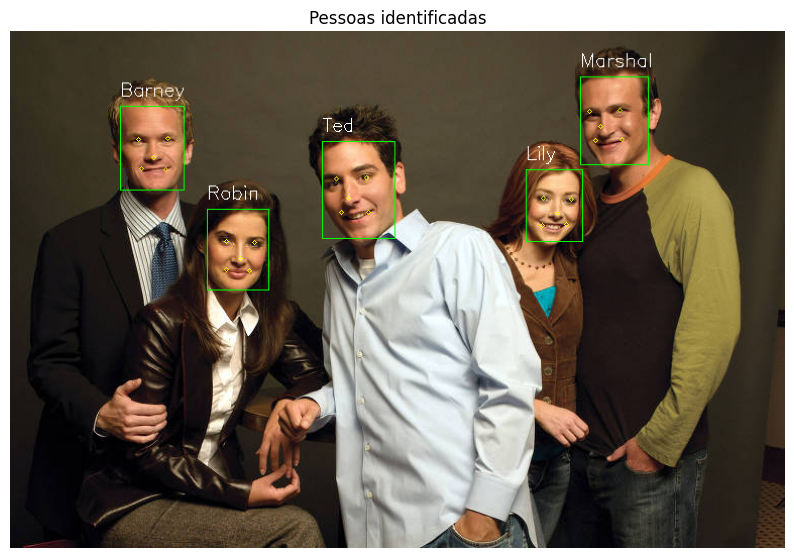

In [3]:
# Identifique aqui a relação de pessoas que deseja reconhecer na mesma ordem da imagem de referência
lista_identidades = ["Barney", "Robin", "Marshal", "Ted", "Lily"]

visualize(img1_base, faces1, tm.getFPS(), labels=lista_identidades)
show_image(img1_base, "Pessoas identificadas")

if save_result:
    cv.imwrite("imagem_referencia.jpg", img1_base)

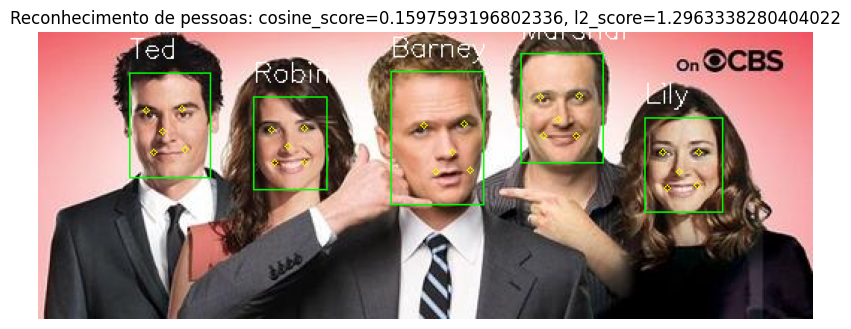

In [4]:
# Realize aqui o teste de reconhecimento utilizando a variável image2_path para registrar o caminho completo para a imagem

image2_path = 'C:/Users/mavga/BairesDev_MLearning/FaceRecog/how_I_met_your_mother/himym2.JPG' # caminho da imagem ou None se não quiser comparar

reconhecer_faces(image1_path, image2_path)




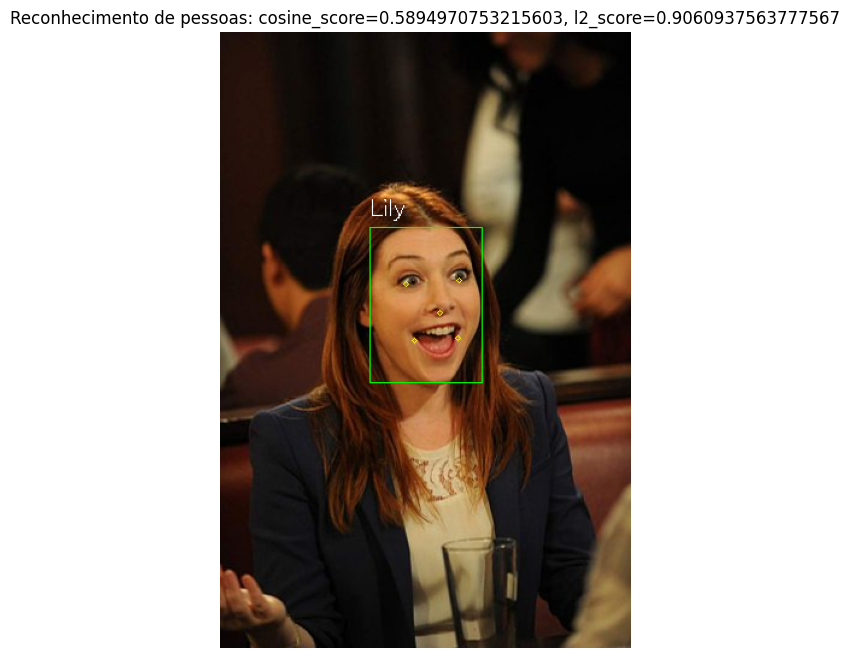

In [5]:

# Realize aqui o teste de reconhecimento utilizando a variável image2_path para registrar o caminho completo para a imagem

image2_path = 'C:/Users/mavga/BairesDev_MLearning/FaceRecog/how_I_met_your_mother/img/L2.JPG' # caminho da imagem ou None se não quiser comparar

reconhecer_faces(image1_path, image2_path)


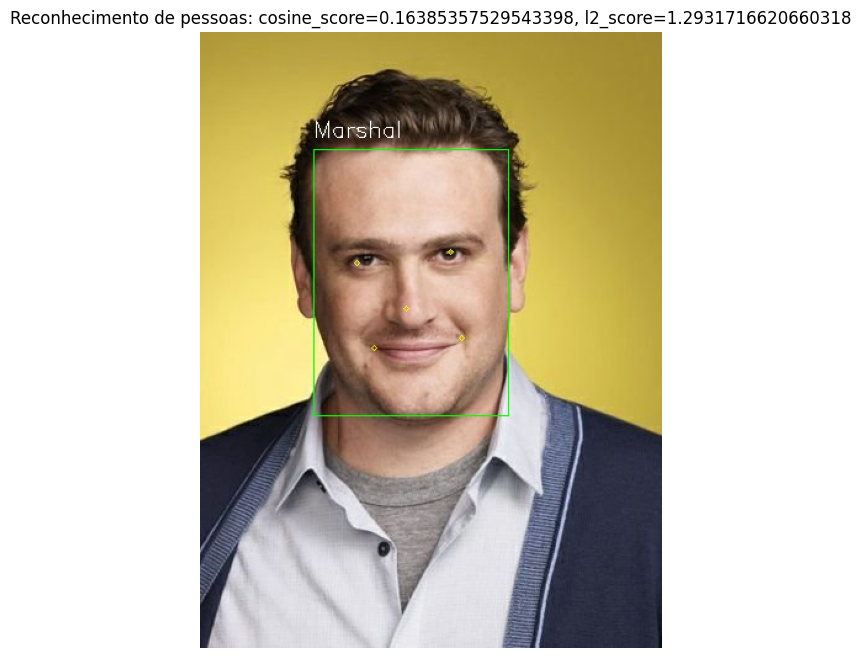

In [6]:
image2_path = 'C:/Users/mavga/BairesDev_MLearning/FaceRecog/how_I_met_your_mother/img/M2.JPG' # caminho da imagem ou None se não quiser comparar

reconhecer_faces(image1_path, image2_path)


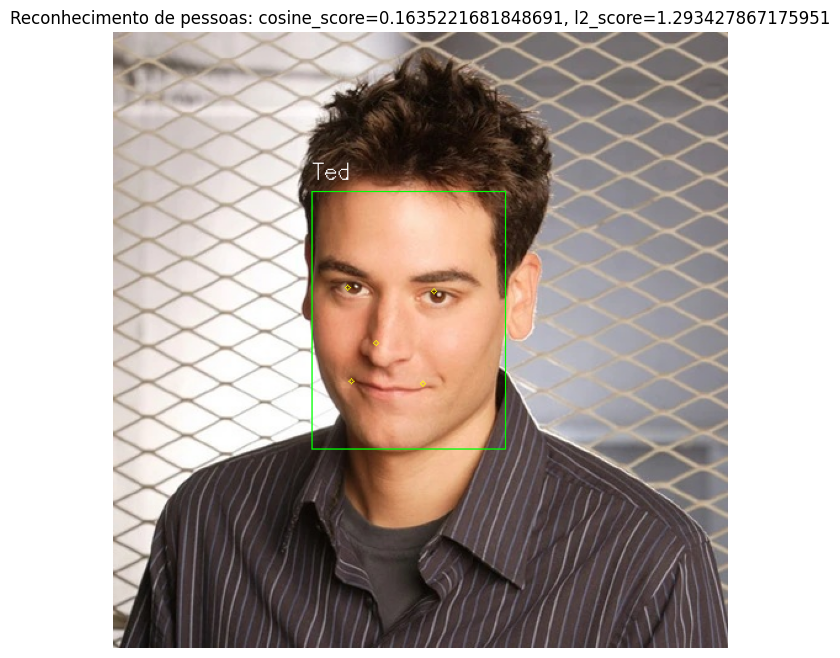

In [8]:
image2_path = 'C:/Users/mavga/BairesDev_MLearning/FaceRecog/how_I_met_your_mother/img/T4.JPG' # caminho da imagem ou None se não quiser comparar

reconhecer_faces(image1_path, image2_path)


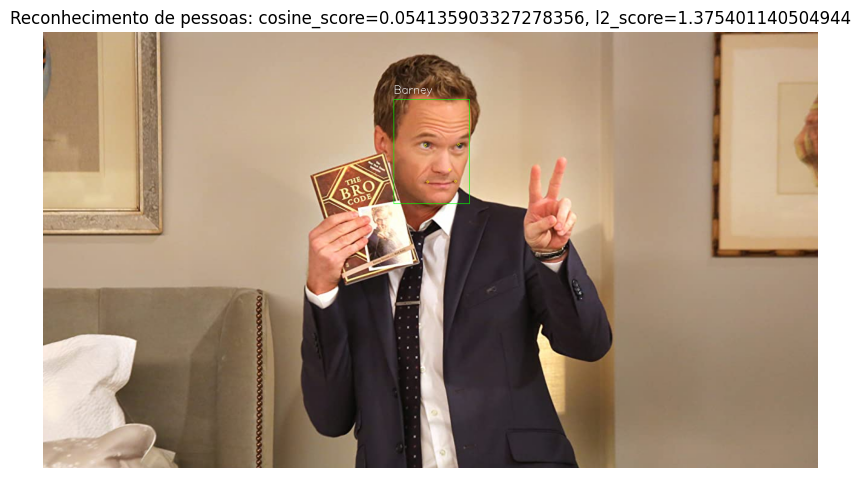

In [9]:
image2_path = 'C:/Users/mavga/BairesDev_MLearning/FaceRecog/how_I_met_your_mother/img/B2.JPG' # caminho da imagem ou None se não quiser comparar

reconhecer_faces(image1_path, image2_path)


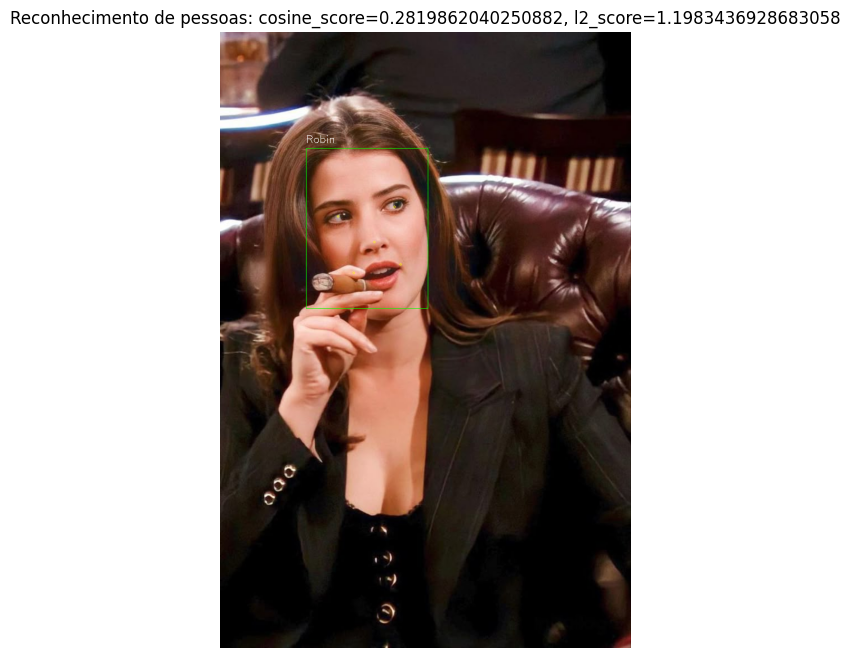

In [10]:
image2_path = 'C:/Users/mavga/BairesDev_MLearning/FaceRecog/how_I_met_your_mother/img/R2.JPG' # caminho da imagem ou None se não quiser comparar

reconhecer_faces(image1_path, image2_path)
